# Covid-19: From model prediction to model predictive control

## A demo of the stochastic modeling framework

*Original code by Ryan S. McGee. Modified by T.W. Alleman in consultation with the BIOMATH research unit headed by prof. Ingmar Nopens.*

Copyright (c) 2020 by T.W. Alleman, BIOMATH, Ghent University. All Rights Reserved.

Our code implements a SEIRS infectious disease dynamics models with extensions to model the effect quarantining detected cases. Using the concept of 'classes' in Python 3, the code was integrated with our previous work and allows to quickly perform Monte Carlo simulations, calibrate model parameters and calculate an *optimal* government policies using a model predictive controller (MPC). A white paper and souce code of our previous work can be found on the Biomath website. 

https://biomath.ugent.be/covid-19-outbreak-modelling-and-control

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from ipywidgets import interact,fixed,FloatSlider,IntSlider,ToggleButtons
import pandas as pd
import datetime
import scipy
from scipy.integrate import odeint
import matplotlib.dates as mdates
import matplotlib
import scipy.stats as st
import networkx
import models

## Introduction

### Model dynamics

In this work, we extended the SEIR model to model the disease spread with a higher resolution. To this end, the *infected pool* is split into four types of infectiousness: 1) supermild (SM): people who show little to no symptoms at all, 2) mild (M): people with noticable, mild covid-19 symptoms, 3) heavy (H): people hospitalised but not in need of intensive care and 4) critical (C): people hospitalised and in need of intensive care. It takes several days before a heavy or critical infection becomes so severe that these patients need to be hospitalised. To this end, the pool of heavily and critically infected patients is split in two: not yet hospitalised (H, C) and hospitalised (HH,CH). The *removed pool* from the classical SEIR model is explicitly split into an immune (I) and dead (F) pool. People from the susceptible, exposed, supermild infected, mild infected and immune pool can be quarantined after having tested positive for covid-19. In the flowchart below, quarantine pools are denoted by the *Q*-suffix. Note that for individuals in the susceptible and immune pools, this corresponds to receiving a false positive test.

<img src="../figs/flowchart2.jpg" alt="drawing" width="400"/>

### Deterministic vs. Stochastic framework

The extended SEIR model is implemented using two frameworks: a deterministic and a stochastic (network based) framework. **This Jupyter Notebooks is a demo of the deterministic model, the stochastic model works but is not yet integrated with our current methods.** A deterministic implementation of the extended SEIRS model captures important features of infectious disease dynamics, but it assumes uniform mixing of the population (i.e. every individual in the population is equally likely to interact with every other individual). The deterministic approach results in a set of N ordinary differential equations, one for every of the N ’population pools’ considered. The main advantage of the deterministic model is that a low amount of computational resources are required while still maintaining an acceptable accuracy. The deterministic framework allows to rapidly explore scenarios and perform optimisations which require thousands of function evaluations. 

However, it is often important to consider the structure of contact networks when studying disease transmission and the effect of interventions such as social distancing and contact tracing. The main drawback of the deterministic approach is the inability to simulate contact tracing, which is one of the most promising measures against the spread of sars-cov-2. For this reason, the SEIRS dynamics depicted in on the above flowchart can be simulated on a stochastic dynamical network. This advantages include a more detailed analysis of the relationship between social network structure and effective transmission rates, including the effect of network-based interventions such as social distancing, quarantining, and contact tracing. The first drawback is the increased amount of computational resources required, leading to the inability to perform optimisations on a personal computer. Instead, high performance computing infrastructure is needed. The second drawback is the need for more data and/or assumptions on social interactions and how government measures affect these social interactions.

#### Deterministic equations
The dynamics of the deterministic system are mathematically formulated as the rate of change of each population pool shown in the above flowchart. This results in the following system of ordinary differential equations,

\begin{eqnarray}
\dot{S} &=& - \beta \cdot N_c \Big( \frac{E+SM}{N} \Big) \cdot S  - \theta_{\text{S}} \psi_{\text{FP}} \cdot S + SQ/d_{\text{q,FP}} + \zeta \cdot R,\\
\dot{E} &=&  \beta \cdot N_c  \Big( \frac{E+SM}{N} \Big) \cdot S - B / \sigma - \theta_{\text{E}} \psi_{\text{PP}} \cdot E,\\
\dot{SM} &=& \text{sm}/\sigma  \cdot E - SM/d_{\text{sm}} - \theta_{\text{SM}} \psi_{\text{PP}} \cdot SM,\\ 
\dot{M} &=&  \text{m} / \sigma \cdot E - M/d_{\text{m}} - \theta_{\text{M}} \psi_{\text{PP}} \cdot M,\\
\dot{H} &=&  \text{h} / \sigma \cdot E + h / \sigma \cdot EQ - H/d_{\text{hospital}},\\
\dot{C} &=&  \text{c} / \sigma \cdot E + c / \sigma \cdot EQ - C/d_{\text{hospital}},\\
\dot{HH} &=& H/d_{\text{hospital}} - HH/d_{h}\\
\dot{CH} &=& C/d_{\text{hospital}} - m_c \cdot CH/d_{\text{cf}} - (1-m_c) \cdot CH/d_{\text{cr}}\\
\dot{F} &=& m_c \cdot CH/d_{\text{cf}}\\
\dot{R} &=& SM/d_{\text{sm}} + M/d_{\text{m}} + HH/d_{\text{h}} + (1-m_h) \cdot CH/d_{\text{cr}} + SMQ/d_{\text{sm}} \\ && + MQ/d_{\text{m}} + RQ/d_{\text{q,FP}} - \zeta \cdot R \\
\dot{SQ} &=& \theta_{\text{S}} \psi_{\text{FP}} \cdot S - SQ/d_{\text{q,FP}} \\
\dot{EQ} &=& \theta_{\text{E}} \psi_{\text{PP}} \cdot E - EQ/\sigma\\
\dot{SMQ} &=& \theta_{\text{SM}} \psi_{\text{PP}} \cdot SM + sm/\sigma \cdot EQ - SMQ/d_{\text{sm}} \\
\dot{MQ} &=& \theta_{\text{M}} \psi_{\text{PP}} \cdot M + m/\sigma \cdot EQ - MQ/d_{\text{m}}\\
\dot{RQ} &=& \theta_{\text{R}} \psi_{\text{FP}} \cdot R - RQ/d_{\text{q,FP}}
\end{eqnarray}

#### Stochastic equations
Consider a network graph G like the one depicted below, representing individuals (nodes) and their interactions (edges). Each individual (node) has a state (S, E, SM, M, H, C, HH, CH, R, F, SQ, SMQ, MQ or RQ). The set of nodes adjacent (connected by an edge) to an individual defines their set of "close contacts" (highlighted in black). At a given time, each individual makes contact with a random individual from their set of close contacts with probability (1-p) or with a random individual from anywhere in the network (highlighted in blue) with probability p. The latter global contacts represent individuals interacting with the population at large. These are individuals outside of ones inner social circle, such as on public transit, at an event or chatting to an old acquaintance etc. When a susceptible individual interacts with an exposed or infectious individual they become exposed themselves. The parameter p defines the locality of the network: for p=0 an individual only interacts with their close contacts, while p=1 represents a uniformly mixed population. **For a sufficiently large network G, and $p = 1$, the stochastic and deterministic framework will yield the same result**. Social distancing interventions ifluences both the locality and connectivity of the network. It is expected that social distancing lowers the average number of interactions an individual has each day (lower connectivity of the network). But as a result, the fraction of interactions in the inner circle increases, lowering p.

<img src="../figs/network_contacts.png"
     alt="network"
     height="180" width="200"     
     style="float: left; margin-right: 10000px;" /> 

Each node $i$ has a state $X_i$ that updates according to a probability transition rate. The dynamics of the stochastic system are mathematically formulated as probabilities of transitioning between the pools shown in the model flowchart. In addition, back tracking of confirmed cases can be included in the model,

\begin{eqnarray}
\text{Pr}(X_i = S \rightarrow E) &=&  \Big[ \underbrace{p \cdot \frac{\beta (E + SM)}{N}}_{\text{infection through random encounter}} \\ 
&& + \underbrace{(1-p) \cdot \frac{\beta \sum_{j \in C_G(i)} (\delta_{X_j = E}+\delta_{X_j = SM})}{C_G (i)}}_{\text{infection through inner circle}} \Big] \delta_{X_i=S},\\
\text{Pr}(X_i = E \rightarrow SM) &=&  (sm/\sigma) \cdot \delta_{X_i = E},\\
\text{Pr}(X_i = E \rightarrow M) &=&  (m/\sigma) \cdot \delta_{X_i = E},\\
\text{Pr}(X_i = E \rightarrow H) &=&  (h/\sigma) \cdot \delta_{X_i = E},\\
\text{Pr}(X_i = E \rightarrow C) &=&  (c/\sigma) \cdot \delta_{X_i = E},\\
\text{Pr}(X_i = H \rightarrow HH) &=&  (1/d_{\text{hospital}}) \delta_{X_i = H},\\
\text{Pr}(X_i = C \rightarrow CH) &=&  (1/d_{\text{hospital}}) \delta_{X_i = C},\\
\text{Pr}(X_i = SM \rightarrow R) &=& (1/d_{\text{sm}}) \cdot \delta_{X_i = SM},\\
\text{Pr}(X_i = M \rightarrow R) &=& (1/d_{\text{m}}) \cdot \delta_{X_i = M},\\
\text{Pr}(X_i = HH \rightarrow R) &=& (1/d_{\text{h}}) \cdot \delta_{X_i = HH},\\
\text{Pr}(X_i = CH \rightarrow R) &=& (1-m_c)/d_{\text{cr}} \cdot \delta_{X_i = HH},\\
\text{Pr}(X_i = CH \rightarrow F) &=& (m_c/d_{\text{cf}}) \cdot \delta_{X_i = HH},\\
\text{Pr}(X_i = S \rightarrow SQ) &=& \Big[\theta_S + \phi_S \big[ \sum_{j \in C_G(i)} (\delta_{X_j = SQ}+\delta_{X_j = EQ}+\delta_{X_j = SMQ} \\
&&+\delta_{X_j = MQ}+\delta_{X_j = RQ}+\delta_{X_j = HH}+\delta_{X_j = CH}) \big] \Big] \cdot \psi_{\text{FP}} \cdot \delta_{X_i = S}, \\
\text{Pr}(X_i = E \rightarrow EQ) &=& \Big[\theta_E + \phi_E \big[ \sum_{j \in C_G(i)} (\delta_{X_j = SQ}+\delta_{X_j = EQ}+\delta_{X_j = SMQ} \\
&&+\delta_{X_j = MQ}+\delta_{X_j = RQ}+\delta_{X_j = HH}+\delta_{X_j = CH}) \big] \Big] \cdot \psi_{\text{PP}} \cdot \delta_{X_i = E}, \\
\text{Pr}(X_i = SM \rightarrow SMQ) &=& \Big[\theta_{SM} + \phi_{SM} \big[ \sum_{j \in C_G(i)} (\delta_{X_j = SQ}+\delta_{X_j = EQ}+\delta_{X_j = SMQ} \\
&&+\delta_{X_j = MQ}+\delta_{X_j = RQ}+\delta_{X_j = HH}+\delta_{X_j = CH}) \big] \Big] \cdot \psi_{\text{PP}} \cdot \delta_{X_i = SM}, \\
\text{Pr}(X_i = M \rightarrow MQ) &=& \Big[\theta_{M} + \phi_{M} \big[ \sum_{j \in C_G(i)} (\delta_{X_j = SQ}+\delta_{X_j = EQ}+\delta_{X_j = SMQ} \\
&&+\delta_{X_j = MQ}+\delta_{X_j = RQ}+\delta_{X_j = HH}+\delta_{X_j = CH}) \big] \Big] \cdot \psi_{\text{PP}} \cdot \delta_{X_i = M} \\
\text{Pr}(X_i = R \rightarrow RQ) &=& \Big[\theta_{R} + \phi_{R} \big[ \sum_{j \in C_G(i)} (\delta_{X_j = SQ}+\delta_{X_j = EQ}+\delta_{X_j = SMQ} \\
&&+\delta_{X_j = MQ}+\delta_{X_j = RQ}+\delta_{X_j = HH}+\delta_{X_j = CH}) \big] \Big] \cdot \psi_{\text{FP}} \cdot \delta_{X_i = R}\\
\text{Pr}(X_i = SQ \rightarrow S) &=& (1/d_{q,FP}) \cdot \delta_{X_i = SQ},\\
\text{Pr}(X_i = EQ \rightarrow SMQ) &=& sm \cdot \sigma \cdot \delta_{X_i = EQ},\\
\text{Pr}(X_i = EQ \rightarrow MQ) &=& m \cdot \sigma \cdot \delta_{X_i = EQ},\\
\text{Pr}(X_i = EQ \rightarrow H) &=& h \cdot \sigma \cdot \delta_{X_i = EQ},\\
\text{Pr}(X_i = EQ \rightarrow C) &=& h \cdot \sigma \cdot \delta_{X_i = EQ},\\
\text{Pr}(X_i = SMQ \rightarrow R) &=& h (1/d_{sm}) \cdot \delta_{X_i = SMQ},\\
\text{Pr}(X_i = MQ \rightarrow R) &=& h (1/d_{m}) \cdot \delta_{X_i = MQ},\\
\text{Pr}(X_i = RQ \rightarrow R) &=& h (1/d_{\text{hospital}}) \cdot \delta_{X_i = RQ},\\
\text{Pr}(X_i = R \rightarrow S) &=& \zeta \cdot \delta_{X_i = R},\\
\end{eqnarray}

where $\delta_{X_i = A} = 1$ if the state of $X_i$ is A, or 0 if not, and where $C_G(i)$ denotes the set of close contacts of node i (adjacent nodes). For large populations and $p = 1$, this stochastic model approaches the same dynamics as the deterministic SEIRS model.

### Model parameters

In the above equations, S stands for susceptible, E for exposed, SM for supermild, M for mild, H for heavy, C for critical, HH for heavy and hospitalised, CH for critical and hospitalised, F for dead, R for immune. The quarantined states are SQ, which stands for susceptible and quarantined, EQ for exposed and quarantined, SMQ for supermild infected and quarantined, MQ for mildly infected and quarantined and RQ for recovered and quarantined. N stands for the total population. The clinical parameters are: sm, m, z, h: the chance of having an asymptotic, mild, heavy or critical infection. Based on reported cases in China and travel data, Li et al. (2020b) estimated that 86 % of coronavirus infections in the country were "undocumented" in the weeks before officials instituted stringent quarantines. A biotech company in Iceland that has tested more than 9,000 people found that around 50 percent of those who tested positive said they were asymptomatic. We assume that 50 % of all infected cases are supermild (asymptotic) and hence,

$$sm = 0.50$$

Based on previously reported estimates of the distribution between mild, severe and critical cases (Wu and McGoogan, 2020), it is then calculated that the chance of contrapting a mild, severe and critical infection is,

$$m = (1 − 0.50) · 0.81 = 0.405,$$
$$h = (1 − 0.50) · 0.14 = 0.070,$$
$$c = (1 − 0.50) · 0.05 = 0.025.$$

$d_{sm}$ , $d_m$ , $d_h$ : the number of symptomic days in case of a supermild, mild or heavy infection. $d_{hf}$ is the time from hospitalisation until death in case of a critical infection while $d_{hr}$ is the recovery time for critical cases. Zhou et al. (2020) performed a retrospective study on 191 Chinese hospital patients and determined that the time from illness onset to discharge or death was 22.0 days (18.0-25.0, IQR) and 18.5 days (15.0-22.0, IQR) for survivors and victims respectively. Using available preliminary data, the World Health Organisation estimated the median time from onset to clinical recovery for mild cases to be approximately 2 weeks and to be 3-6 weeks for patients with severe or critical disease (WHO, 2020). Based on this report, we assume a recovery time of three weeks for heavy infections. d hospital : the time before heavily or critically infected patients reach the hospital. On average this is 9.1 days (Li et al., 2020a). m c : the mortality in case of a critical infection, which is roughly 50% (Wu and McGoogan, 2020). It is assumed that if the number of critical cases surpasses the total number of ICU beds, the mortality is changed to the average between 0.49 and 1, with the fraction of patients in critical condition receiving care as a weight. This is formulated mathematically in the following way,

\begin{equation}
m_h = \underbrace{\Big( \frac{ICU_{\text{max}}}{H} \Big) \cdot 0.49}_{\text{critical patient receives care}} + \underbrace{\Big( \frac{H - ICU_{\text{max}}}{H} \Big) \cdot 1.00}_{\text{critical patient receives no care}}\ .
\end{equation}

$\sigma$: the incubation period in days. The incubation period is assumed to be Erlang distributed as reported by Li et al. (2020a). The average incubation time is 5.2 days. $\zeta$: can be used to model the effect of re-susceptibility and seasonality of a disease. Throughout this demo, we assume $\zeta = 0$ because data on seasonality is not yet available at the moment. We thus assume permanent immunity after recovering from the infection.

The transmission rate of the disease in the deterministic model depends on the product of three contributions. The first contribution, $(E+SM)/N$, is the probability of encountering a contagious individual. The second contribution, $N_c$, is the average number of human-to-human interactions per day. As previously explained, **in the deterministic framework, this means all $N_c$ contacts within the population are random**. In this work, we explictly split $\beta$ and $N_c$ because this has the following advantages: 1) $\beta$ is now a disease characteric, independent of social interactions. 2) The goal of this work is to demonstrate the concept of social control to contain the outbreak using model predictive control. By splitting $\beta$ and $N_c$, the controlled variable is the number of random contacts $N_c$ which is more comprehendible to the reader of this text. The number of human-human interactions per day is estimated using the Social Contact Rates (SOCRATES) Data Tool (Willem et al., 2020). The dataset on human-human interactions for Belgium is based on a 2008 study by Mossong, which kept track of 750 participants and their interactions (8878 interactions) in Belgium. The dataset includes both physical and non-physical interactions of any duration. The third contribution, $\beta$, is the probability of contracting sars-cov-2 when encoutering a contagious individual. The testing and quarantine parameters are: $\theta_{S}$, $\theta_{E}$, $\theta_{SM}$, $\theta_{M}$, $\theta_{R}$ expressed as the number of susceptibles, exposed, supermild and mild individuals tested each day. It is difficult to model a concrete testing scenario in the deterministic framework because no back tracing can be coupled to the tests. The deterministic model only considers random testing of the population. It uses the total daily testing capacity to calculate the amount of individuals in the S, E, SM, M and R pool that receive a test. $\psi_{PP}$: probability of correctly identifiying and quarantining an exposed or infected person. $\psi_{FP}$: probability of falsly identifying and quarantining a susceptible or recovered individual. Both parameters can be calculated using the reliability of the test and Bayes theorem. For now, we assume no false positives. $d_{\text{q,FP}}$: the duration of the quarantine in the case of a false positive, assumed to be 14 days.

### Social interaction data

#### Social Contact Rates (SOCRATES) Data Tool

https://lwillem.shinyapps.io/socrates_rshiny/

1. What is the average number of daily human-to-human contacts of the Belgian population? Include all ages, all genders and both physical and non-physical interactions of any duration. To include all ages, type: *0,60+* in the *Age Breaks* dialog box.
2. What is the average number of physical human-to-human contacts of the Belgian population? Include all ages, all genders and all durations of physical contact.
3. What is the average number of physical human-to-human contacts of at least 1 hour of the Belgian population?
4. Based on the above results, how would you estimate $N_c$ in the deterministic model?
5. Based on the above results, how would you estimate $p$ in the stochastic model? Recall that $p$ is the fraction of *random contacts* a person has on a daily basis, while $(1-p)$ is the fraction of *inner circle contacts* a person has on a daily basis.

#### Google COVID-19 Community Mobility Reports

https://www.google.com/covid19/mobility/

#### London School of Hygiene

https://www.thelancet.com/journals/lanpub/article/PIIS2468-2667(20)30073-6/fulltext

## Performing simulations

### Without age-structuring

#### The 'SEIRSNetworkModel' class

The *SEIRSNetworkModel* class uses the exact same class structure and function names as the *SEIRSAgeModel* deterministic class, which is detailed below.

<img src="../figs/SEIRSNetworkModel.jpg"
     alt="class"
     height="600" width="700"     
     style="float: left; margin-right: 500px;" /> 

As of now (20/04/2020), the SEIRSNetworkModel contains 5 functions which can be grouped in two parts: 1) functions to run and visualise simulations and 2) functions to perform parameter estimations and visualse the results. Implementing the model predictive controller is straightforward and can easily be done. However, the optimisation problem is really difficult and requires thousands of function evaluations. Given the large amount of computational resources required to run just one stochastic simulation, it is highly unlikely that the model predictive controller will ever be used to optimize government policy. The MPC functions will be implemented and their usefullness assessed after a calibration is performed. Also, scenario specific functions will be added over the course of next week. 

#### Creating a SEIRSNetworkModel object

Before a stochastic simulation can be performed, the interaction network G, which determines the connectivity of the network model, must be defined. In the example below, an interaction network under normal circumstances and an interaction network under distancing measures is initiated. Switching between networks is possible during a simulation.

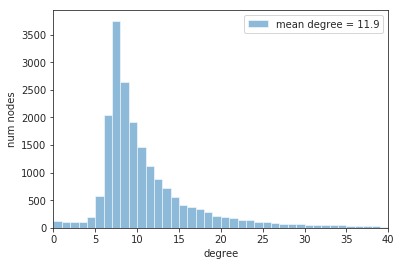

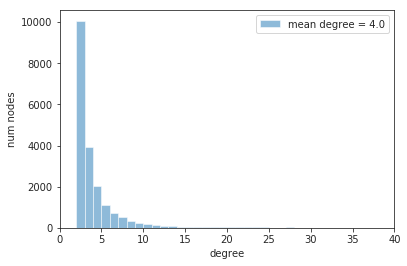

In [19]:
# Construct the network G
numNodes = 20000
baseGraph    = networkx.barabasi_albert_graph(n=numNodes, m=7)
# Baseline normal interactions:
G_norm     = models.custom_exponential_graph(baseGraph, scale=200)
models.plot_degree_distn(G_norm, max_degree=40)

# Construct the network G under social distancing
numNodes = 20000
baseGraph    = networkx.barabasi_albert_graph(n=numNodes, m=2)
# Baseline normal interactions:
G_dist     = models.custom_exponential_graph(baseGraph, scale=20000)
models.plot_degree_distn(G_dist, max_degree=40)

In [25]:
model = models.SEIRSNetworkModel(
                                 # network connectivty
                                 G = G_norm,
                                 p       = 0.6,
                                 # clinical parameters
                                 beta    = 0.05, 
                                 sigma   = 5.2,
                                 zeta    = 0,
                                 sm      = 0.50,
                                 m       = (1-0.50)*0.81,
                                 h       = (1-0.50)*0.15,
                                 c       = (1-0.50)*0.04,
                                 dsm     = 14,
                                 dm      = 14,
                                 dhospital = 1,
                                 dh      = 21,
                                 dcf     = 18.5,
                                 dcr     = 22.0,
                                 mc0     = 0.49,
                                 ICU     = 2000,
                                 # testing
                                 theta_S = 0,
                                 theta_E = 0,
                                 theta_SM= 0,
                                 theta_M = 0,
                                 theta_R = 0,
                                 psi_FP = 0,
                                 psi_PP = 1,
                                 dq     = 14,                                 
                                 # back-tracking
                                 phi_S   = 0,
                                 phi_E   = 0,
                                 phi_SM  = 0,
                                 phi_R   = 0,
                                 # initial condition
                                 initN = 11.43e6, #results are extrapolated to entire population
                                 initE = 10,
                                 initSM = 0, 
                                 initM = 0,
                                 initH = 0,
                                 initC = 0,
                                 initHH = 0,
                                 initCH = 0,
                                 initR = 0,
                                 initF = 0,
                                 initSQ = 0,
                                 initEQ = 0,
                                 initSMQ = 0,
                                 initMQ = 0,
                                 initRQ = 0,
                                 # monte-carlo sampling
                                 monteCarlo = True,
                                 repeats = 30
                            )

#### Altering an object variable after intialisation

After initialising our 'model' it is still possible to change variables using the following syntax.

In [26]:
model.beta = 0.30

#### Running your first simulation

A simulation is run by using the attribute function *sim*, which uses one argument, the simulation time T, as its input. 

In [9]:
y = model.sim(100)

t = 0.05
t = 20.06
t = 30.12
t = 40.01
t = 50.19
t = 60.02
t = 70.01
t = 80.00
t = 90.00
t = 100.00
t = 0.24
t = 10.23
t = 20.01
t = 30.11
t = 40.03
t = 50.01
t = 60.01
t = 70.01
t = 80.00
t = 90.00
t = 100.01
t = 0.06
t = 10.39
t = 0.13
t = 0.25
t = 0.21
t = 0.01
t = 0.06
t = 0.49
t = 0.03


For advanced users: the numerical results of the simulation can be accessed directly be calling *object.X* or *object.sumX* where X is the name of the desired population pool. Both are numpy arrays. *Ojbect.X* is a 3D array of the following dimensions:
- x-dimension: number of age categories,
- y-dimesion: tN: total number of timesteps taken (one per day),
- z-dimension: n_samples: total number of monte-carlo simulations performed.

Object.sumX is a 2D array containing only the results summed over all age categorie and has the following dimensions,
- x-dimesion: tN: total number of timesteps taken (one per day),
- y-dimension: n_samples: total number of monte-carlo simulations performed.


#### Visualising the results

To quickly visualise simulation results, two attribute functions were created. The first function, *plotPopulationStatus*, visualises the number of susceptible, exposed, infected and recovered individuals in the population. The second function, *plotInfected*, by default visualises the number of heavily and critically infected individuals. Both functions require no user input to work but both have some optional arguments,

> plotPopulationStatus(filename),
> - filename: string with a filename + extension to save the figure. The figure is not saved per default.

> plotInfected(asymptotic, mild, filename),
> - asymptotic: set to *True* to include the supermild pool in the visualisation.
> - mild: set to *True* to include the mild pool in the visualisation.
> - filename: string with a filename + extension to save the figure. The figure is not saved per default.

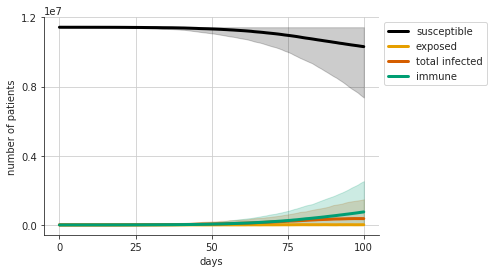

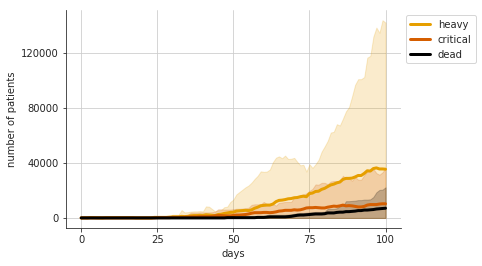

In [10]:
model.plotPopulationStatus()
model.plotInfected()

#### The use of checkpoints to change parameters on the fly

A cool feature of the original SEIRSplus package by Ryan McGee was the use of so-called *checkpoints* dictionary to change simulation parameters on the fly. In our modification, this feature is preserved. Below you can find an example of a *checkpoints* dictionary. The simulation will be started with the previously initialised parameters. After 40 days, social interaction will be limited by lowering the network connectivity to an average of 4 edges per node. The chance of random encounters is lowered to 10%. After 80 days, social restrictions are lifted and beta once more assumes its *business-as-usual* value. *checkpoints* is the only optional argument of the *sim* functions and is set to *None* per default.

In [ ]:
# Create checkpoints dictionary
chk = {'t':       [15,80], 
       'G':       [G_dist,G_norm],
       'p':       [0.01,0.3],
      }
# Run simulation
y = model.sim(90,checkpoints=chk)
# Visualise
model.plotPopulationStatus()
model.plotInfected()

t = 0.00
t = 10.07
[Checkpoint: Updating parameters]
t = 20.17
t = 30.01
t = 40.02
t = 50.04
t = 60.02
t = 70.02
[Checkpoint: Updating parameters]
t = 80.01
t = 90.00
t = 0.03
t = 10.18
[Checkpoint: Updating parameters]
t = 40.05
t = 0.00
t = 10.08
[Checkpoint: Updating parameters]
t = 20.01
t = 30.03
[Checkpoint: Updating parameters]
t = 80.90
t = 0.09
t = 10.08
[Checkpoint: Updating parameters]
t = 20.08
t = 30.14
t = 40.53
[Checkpoint: Updating parameters]
t = 80.05
t = 90.02
t = 0.03
t = 10.00
[Checkpoint: Updating parameters]
t = 20.03
t = 30.01
t = 40.04
t = 50.02
t = 60.04
t = 70.04
[Checkpoint: Updating parameters]
t = 80.86
t = 90.22
t = 0.03
t = 10.01
[Checkpoint: Updating parameters]
t = 20.15
t = 30.06
t = 40.12
t = 50.22
t = 60.37
t = 70.13
[Checkpoint: Updating parameters]
t = 80.67
t = 90.03
t = 0.03
t = 10.00
[Checkpoint: Updating parameters]
t = 20.04
t = 30.00
t = 40.00
t = 50.00
t = 60.01
t = 70.00
[Checkpoint: Updating parameters]
t = 80.00
t = 90.00
t = 0.01
t = 10

## Calibrating $\beta$  in a *business-as-usual* scenario ($N_c = 11.2$)

### Performing a least-squares fit

The 'SEIRSNetworkModel' class contains a function to fit the model to selected data (*fit*) and one function to visualise the result (*plotFit*). Our code uses the **genetic algorithm** from scipy to perform the optimisation. The *fit* function has the following basic syntax,

> sim(data, parNames, positions, bounds, weights)
> - data: a list containing the dataseries (dtype=np array) to fit the model to. For now, dataseries must be of equal length.
> - parNames: a list containing the names (dtype=string) of the model parameters to be fitted.
> - positions: a list containing the model states (dtype=np.array) used to calculate the sum of least squares. Each dataseries must be matched to a certain (sum of) model state(s). If multiple entries are provided these are added togheter. The order of the states is given according to the following vector, where S has index 0: (S, E, SM, M, H, C, HH, CH, R, F, SQ, EQ, SMQ, MQ, RQ).


The following arguments are optional,
> - checkpoints: checkpoint dictionary can be used to calibrate under specific scenarios such as policy changes (default: None).
> - setvar: True to replace fitted values in model object after fit is performed (default: False).
> - disp: Show sum-of-least-squares after each optimisation iteration (default: True).
> - polish: True to use a Nelder–Mead simplex to polish the final result (default: True).
> - maxiter: Maximum number of iterations (default: 30).
> - popsize: Population size of genetic algorithm (default: 10).

The genetic algorithm will by default use all cores available for the optimisation. Using the *fit* attribute, it is possible to calibrate any number of model parameters to any sets of data. We do note that fitting the parameters sm,m,h and c requires modification of the source code. In the example below, the transmission parameter $\beta$ is sought after using two dataseries. The first is the number of patients in need of intensive care and the second is the total number of people in the hospital. The number of patients in ICU is matched with the CH population pool while the number of hospitalisations is matched with the sum of the HH and CH population pools.

In [6]:
# hardcoded data vectors
ICUvect= np.array([[5,24,33,53,79,100,130,164,238,290,322,381,474,605,690,789,867,927,1021,1088,1144,1205,1245,1261,1257,1260,1276,1285,1278,1262,1232,1234,1223]])
hospital = np.array([[58,97,163,264,368,496,648,841,1096,1380,1643,1881,2137,2715,3068,3640,4077,4468,4884,4975,5206,5358,5492,5509,5600,5738,5692,5590,5610,5635,5409,5393,5536]])
# vector with dates
index=pd.date_range('2020-03-13', freq='D', periods=ICUvect.size)
# data series used to calibrate model must be given to function 'plotFit' as a list
idx = -26
index = index[0:idx]
data=[np.transpose(ICUvect[:,0:idx]),np.transpose(hospital[:,0:idx])]
# set optimisation settings
parNames = ['beta','p'] # must be a list!
positions = [np.array([7]),np.array([6,7])] # must be a list!
bounds=[(1,100),(0.1,1),(0.1,1)] # must be a list!
weights = np.array([1,0])
# run optimisation
theta = model.fit(data,parNames,positions,bounds,weights,setvar=True,maxiter=5,popsize=5)

12
No constraints given.
t = 0.01
t = 0.01
t = 10.48
t = 0.01
t = 10.62
t = 0.01
t = 0.01


Process ForkPoolWorker-5:
Process ForkPoolWorker-8:
Traceback (most recent call last):
Process ForkPoolWorker-3:
Process ForkPoolWorker-7:
Process ForkPoolWorker-10:
Process ForkPoolWorker-1:
Process ForkPoolWorker-6:
Process ForkPoolWorker-4:
Process ForkPoolWorker-11:
Process ForkPoolWorker-12:
Process ForkPoolWorker-9:
Process ForkPoolWorker-2:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/twallema/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/twallema/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/twallema/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/twallema/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/twallema/anac

  File "/home/twallema/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
KeyboardInterrupt
  File "/home/twallema/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/home/twallema/Documents/PhD/Corona/Python/git/COVID19-Model/src/models.py", line 1989, in run
    running = self.run_iteration()
KeyboardInterrupt
  File "/home/twallema/anaconda3/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/twallema/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/home/twallema/Documents/PhD/Corona/Python/git/COVID19-Model/src/models.py", line 1874, in run_iteration
    propensities_flat   = propensities.ravel(order='F')
KeyboardInterrupt


KeyboardInterrupt: 

### Visualising the fit

Visualising the resulting fit is easy and can be done using the plotFit function. The functions uses the following basic syntax,

> plotFit(index,data,positions)
> - index: vector with timestamps corresponding to data.
> - data: list containing the dataseries (dtype=np array) to fit the model to. For now, dataseries must be of equal length.
> - positions: list containing the model states (dtype=np.array) used to calculate the sum of least squares.

The following arguments are optional,
> - dataMkr: list containing the markers (dtype=str) to be used to visualise the data. Default value works up to five dataseries and is equal to: ['o','v','s','*','^'].
>- modelClr: list containing the colors (dtype=str) to be used to visualise the model fit. Default value works up to five dateseries and is equal to: ['green','orange','red','black','blue'].
> - legendText: tuple containing the legend entries. Disabled per default.
> - titleText: string containing the fit title. Disable per default.
> - filename: string with a filename + extension to save the figure. The figure is not saved per default.

t = 0.08
t = 10.00
t = 20.13
t = 30.00
t = 40.01


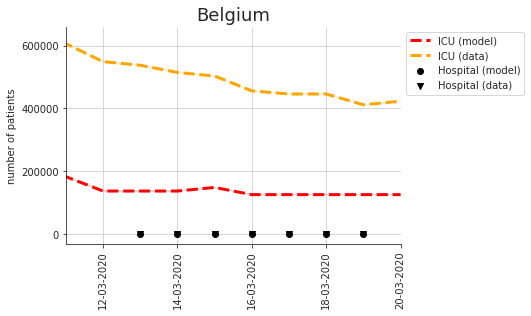

In [9]:
# plot result
model.plotFit(index,data,positions,modelClr=['red','orange'],legendText=('ICU (model)','ICU (data)','Hospital (model)','Hospital (data)'),titleText='Belgium')

# Code works untill here

To be continued...

## Model Predictive control (MPC)

### Optimising government policy

#### Process control for the layman

As we have the impression that the control part, which we see as our main addition to the problem, is more difficult to grasp for the layman, here is a short intro to process control. Experts in control are welcome to skip this section.

A predictive model consists of a set of equations and aims to predict how the system will behave in the future given a certain input. Process control flips this around and aims at determining what input is needed to achieve a desired system behavior (= goal). It is a tool that helps us in “controlling” how we want a system to behave. It is commonly applied in many industries, but also in our homes (e.g. central heating, washing machine). It's basically everywhere. Here's how it works. An algorithm monitors the deviation between the goal and the true system value and then computes the necessary action to "drive" the system to its goal by means of an actuator (in industry this is typically a pump or a valve). Applying this to Covid-19, the government wants to "control" the spread of the virus in the population by imposing measures (necessary control actions) on the public (which is the actuator here) and achieve the goal that the number of severely sick people does not become larger than can be handled by the health care system. However, the way the population behaves is a lot more complex compared to the heating control in our homes since not only epidemiology (virus spread) but also different aspects of human behavior on both the individual and the societal level (sociology, psychology, economy) are involved. This leads to multiple criteria we want to ideally control simultaneously and we want to use the "smartest" algorithm we can get our hands on.

#### The optimizePolicy function

The 'SEIRSNetworkModel' class contains an implementation of the MPC controller in the function *optimizePolicy*. For now, the controller minimises a weighted squared sum-of-errors between multiple setpoints and model predictions. The algorithm can use any variable to control the virus outbreak, but we recommend sticking with the number of random daily contacts $N_c$ and the total number of random tests ('totalTests') as only these have been tested. We also recommend disabling age-structuring in the model before running the MPC as this feature requires discretisation of the interaction matrix to work which is not yet implemented. Future work will extend the MPC controller to work with age-structuring feature inherent to the model. Future work is also aimed at including an economic cost function to discriminate between control handles. Our MPC uses the **genetic algorithm** from scipy.optimize to perform the optimisation, we recommend using at least a populationsize of 20 and at least 100 iterations to ensure that the trajectory is 'optimal'. The *optimizePolicy* function has the following basic syntax,

> optimizePolicy(parNames, bounds, setpoints, positions, weights)
> - parNames: a list containing the names (dtype=string) of the model parameters to be used as a control handle.
> - bounds: A list containing the lower- and upper boundaries of each parameter to be used as a control handle. Each entry in the list should be a 1D numpy array containing the lower- and upper bound for the respective control handle.
> - setpoints: A list with the numerical values of the desired model output.
> - positions: a list containing the model states (dtype=np.array) used to calculate the sum of least squares. Each modelouput in the given position is matched with a provided setpoint. If multiple position entries are provided, the output in these positions is added togheter. The order of the states is given according to the following vector, where S has index 0: (S, E, SM, M, H, C, HH, CH, R, F, SQ, EQ, SMQ, MQ, RQ).


The following arguments are optional,
> - policy_period: length of one policy interval (default: 7 days).
> - N: number of future policy intervals to be optimised, also called 'control horizon' (default: 6).
> - P: number of policy intervals over which the sum of squared errors is calculated, also called 'prediction horizon' (default:12).
> - disp: Show sum-of-least-squares after each optimisation iteration (default: True).
> - polish: True to use a Nelder–Mead simplex to polish the final result (default: True).
> - maxiter: Maximum number of iterations (default: 100).
> - popsize: Population size of genetic algorithm (default: 20).

The function returns a one-dimensional list containing the optimal values of the control handles. The length of this list is equal to the length of the control horizon (N) times the number of control handles. The list thus lists all control handles and their optimal values in their respective order. **The optimal policy is assigned to the SEIRSNetworkModel object and is only overwritten when a new optimisation is performed. Future work could include the creation of a new object for every optimal policy.** The genetic algorithm will by default use all cores available for the optimisation.

In [10]:
parNames = ['Nc','totalTests']
bounds = [np.array([0,11.2]),np.array([0,1e6])]
setpoints = [1200,5000]
positions = [np.array([7]),np.array([6,7])]
weights = [1,0]
model.optimizePolicy(parNames,bounds,setpoints,positions,weights,policy_period=30,N=6,P=12,polish=False,maxiter=1,popsize=10)

AttributeError: 'SEIRSNetworkModel' object has no attribute 'optimizePolicy'

### Visualising the effect of government policy

Visualising the resulting optimal policy is easy and can be done using the plotOptimalPolicy function. We note that the functionality of*plotOptimalPolicy** is for now, very basic and will be extended in the future. The function is heavily based on the *plotInfected* visualisation. The function uses the following basic syntax,

> plotOptimalPolicy(parNames,setpoints,policy_period)
> - parNames: a list containing the names (dtype=string) of the model parameters to be used as a control handle.
> - setpoints: A list with the numerical values of the desired model output.
> - policy_period: length of one policy interval (default: 7 days).

The following arguments are optional,
> - asymptotic: set to *True* to include the supermild pool in the visualisation.
> - mild: set to *True* to include the mild pool in the visualisation.
> - filename: string with a filename + extension to save the figure. The figure is not saved per default.

In [ ]:
model.plotOptimalPolicy(parNames,setpoints,policy_period=14)

## Scenario-specific extensions

### *realTimeScenario*

The 'SEIRSNetworkModel' class contains one function to quickly perform and visualise scenario analysis for a given country. The user is obligated to supply the function with: 1) a set of dataseries, 2) the date at which the data starts, 3) the positions in the model output that correspond with the dataseries and 4) a checkpoints dictionary containing the past governement actions, from hereon referred to as the *pastPolicy* dictionary. If no additional arguments are provided, the data and the corresponding model fit are visualised from the user supplied start date up until the end date of the data plus 14 days. The end date of the visualisation can be altered by defining the optional keyworded argument *T_extra* (default: 14 days). Optionally a dictionary of future policies can be used to simulate scenarios starting on the first day after the end date of the dataseries. The function *realTimeScenario* accomplishes this by merging both the *pastPolicy* and *futurePolicy* dictionaries using the backend function *mergeDict()*. The syntax without optional arguments is as follows,

> realTimeScenario(startDate, data, positions, pastPolicy)
> - startDate: a string with the date corresponding to the first entry of the dataseries (format: 'YYYY-MM-DD'). 
> - data: a list containing the dataseries (dtype=np array) to fit the model to. For now, dataseries must be of equal length and start on the same day.
> - positions: a list containing the model states (dtype=np.array) used to calculate the sum of least squares. Each dataseries must be matched to a certain (sum of) model state(s). If multiple entries are provided these are added togheter. The order of the states is given according to the following vector, where S has index 0: (S, E, SM, M, H, C, HH, CH, R, F, SQ, EQ, SMQ, MQ, RQ).
> - pastPolicy: a checkpoints dictionary containing past government actions.

The following (simulation) arguments are optional,
> - futurePolicy: a checkpoint dictionary used to simulate scenarios in the future (default: None). By default, time '1' in this dictionary is the date of the first day after the end of the data.
> - T_extra: Extra simulation time after last date of the data if no futurePolicy dictionary is provided. Extra simulation time after last time in futurePolicy dictionary.

The following arguments are for visualisation,
> - dataMkr: list containing the markers (dtype=str) to be used to visualise the data. Default value works up to five dataseries and is equal to: ['o','v','s','*','^'].
>- modelClr: list containing the colors (dtype=str) to be used to visualise the model fit. Default value works up to five dateseries and is equal to: ['green','orange','red','black','blue'].
> - legendText: tuple containing the legend entries. Disabled per default.
> - titleText: string containing the fit title. Disable per default.
> - filename: string with a filename + extension to save the figure. The figure is not saved per default.

In [ ]:
# Define data as a list containing data timeseries
data=[np.transpose(ICUvect),np.transpose(hospital)]
# Create a dictionary of past policies
pastPolicy = {'t':       [11], 
              'G':       [G_dist],
              'p':       [0.03]
              }
# Create a dictionary of future policies
futurePolicy = {'t':     [1], 
              'G':       [G_norm],
              'p':       [0.6]
              }
# Define the data corresponding to the first data entry
startDate='2020-03-13'
# Run realTimeScenario
model.realTimeScenario(startDate,data,positions,pastPolicy,futurePolicy=futurePolicy,T_extra=7,
                       modelClr=['red','orange'],legendText=('ICU (model)','Hospital (model)','ICU (data)','Hospital (data)'),
                       titleText='Belgium')